In [1]:
%matplotlib inline
import scipy.signal
import matplotlib
import matplotlib.pyplot as pl
import numpy as np
import itertools
from commpy.filters import rrcosfilter
import math
import random


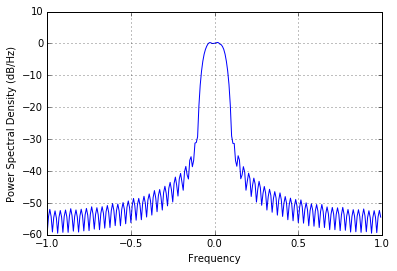

In [66]:
N_data = int(8192)
BR=33e9
analog_rate=16*BR
fix_adc_rate=5/3*BR
import random
N_data = int(10*1024)

def gen_data_rx(alfa=0.1):
    data = np.array([complex(2*random.randint(0,1)-1,2*random.randint(0,1)-1) for i in xrange(N_data)])
    data_zeros = np.zeros((N_data*16,1),dtype=complex).flatten()
    data_zeros[1::16] = data    
    rcos_filter = rrcosfilter(64,alfa,1/BR,16*BR)[1]
    power_of_filter = np.sqrt(np.sum([ np.square(j) for j in rcos_filter]))
    rcos_filter = rcos_filter/power_of_filter
    data_interp = np.convolve(rcos_filter, data_zeros,'same')
    return data_interp

def gen_noise(SNRdb=13):
    sigma_noise = 1/np.sqrt(10**(SNRdb/10.0))
    noise = np.array([complex(np.random.normal(scale=sigma_noise),np.random.normal(scale=sigma_noise)) for i in xrange(N_data*16)])
    return noise
    
Signal = gen_data_rx(0.5)
Noise=gen_noise()
pl.psd(Signal)
#pl.psd(Noise)
#pl.psd(np.add(Signal,Noise))
pl.show()


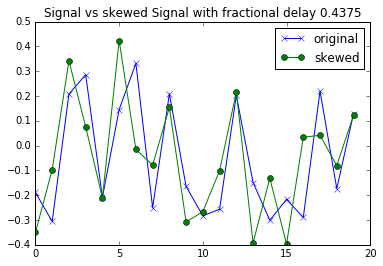

In [67]:
from fractions import Fraction
a=Fraction(fix_adc_rate/analog_rate)
N_proc=512
sk_in_samples=7
def sample_data():
    sampled_data=scipy.signal.resample(Signal[:N_proc*8],int(N_proc*8*a))
    skewed_data=scipy.signal.resample(Signal[sk_in_samples:N_proc*8+sk_in_samples],int(N_proc*8*a))
    return (sampled_data,skewed_data)

(sampled_data,skewed_data) = sample_data()
pl.plot(np.real(sampled_data[-20:]),'-x',label='original')
pl.plot(np.real(skewed_data[-20:]),'o-',label='skewed')
pl.title('Signal vs skewed Signal with fractional delay {0}'.format(sk_in_samples/16.0))
pl.legend()
pl.show()

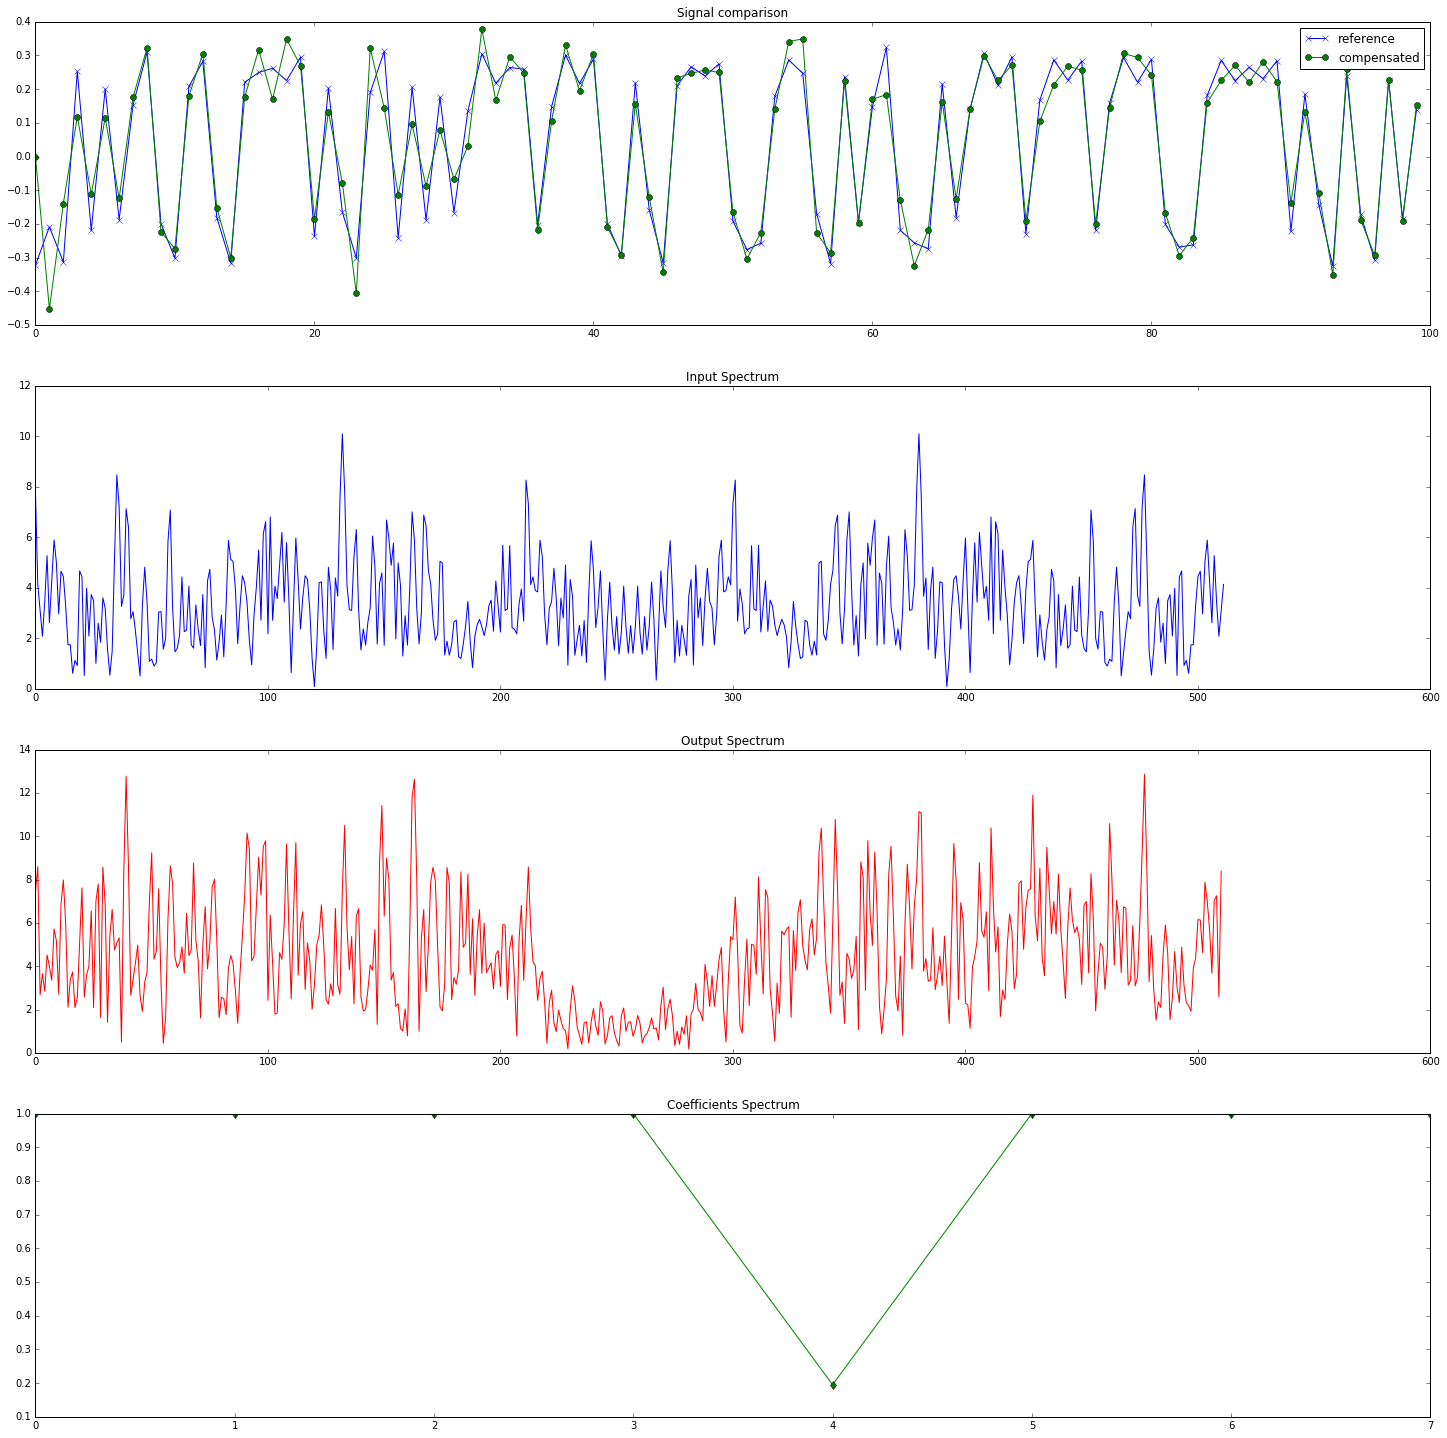

[ 1.00000000+0.j          0.94154407-0.33688985j  0.77301045-0.63439328j
  0.51410274-0.85772861j  0.19509032+0.j          0.51410274+0.85772861j
  0.77301045+0.63439328j  0.94154407+0.33688985j]


In [68]:
fft_size=8#len(sampled_data)
def fd_compensation():
    D=1.0*sk_in_samples/16
    
    y=np.zeros((1,1))
    phases_pos = [np.exp(np.complex(0,-i*(D)*2*np.pi/fft_size)) for i in range(1,fft_size/2)]
    phases_neg = [np.exp(np.complex(0,(fft_size-i)*(D)*2*np.pi/fft_size)) for i in range(fft_size/2+1,fft_size)]
    phases_pos = np.append(1,phases_pos)
    phases_neg = np.append(np.real(np.exp(np.complex(0,-(D)*np.pi))),phases_neg)
    phases= np.append(phases_pos,phases_neg)
    for i in range(N_proc/fft_size):
        regress=fft_size-2
        x=skewed_data[i*(regress):(i*regress)+fft_size]
        f=np.fft.fft(x,fft_size)
        g=np.array([f[i]*phases[i] for i in range(fft_size)])
        y=np.append(y,np.fft.ifft(g,fft_size)[1:-1])
    return (x,y,f,g,phases)

(x,y,f,g,phases)=fd_compensation()
pl.figure(figsize=(25,25))
pl.title('FD Results')
pl.subplot(4,1,1)
pl.title('Signal comparison')
pl.plot(np.imag(sampled_data[:100]),'-x',label='reference')
pl.plot(np.imag(y[:100]),'-o',label='compensated')
pl.legend()
pl.subplot(4,1,2)
pl.title('Input Spectrum')
pl.plot(abs(np.fft.fft(np.real(skewed_data),512)))
pl.subplot(4,1,3)
pl.title('Output Spectrum')
pl.plot(abs(np.fft.fft(y,512))[:511],'r')
pl.subplot(4,1,4)
pl.title('Coefficients Spectrum')
pl.plot(np.abs((phases)),'g-d')

pl.show()
print phases

In [69]:
def td_compensation():
    n_index=64
    n_taps=6                   
    d = sk_in_samples*4.0/n_index;
    D = d + math.ceil(n_taps/2)-1;
    x=skewed_data
    taps=[]
    for j in range(n_taps):     # // Taps Generation
        c_double = 1.0
        for k in range(n_taps): #// Products Generation
            if (k!=j):
              c_double = c_double * ((D-k)/(j-k))
        taps.append(c_double)
    taps.reverse()
    y = [  sum(taps*x[i:i+6]) for i in range(len(x)-6)]
    
    return y,taps
z,taps=td_compensation()



In [70]:
len(z)

250

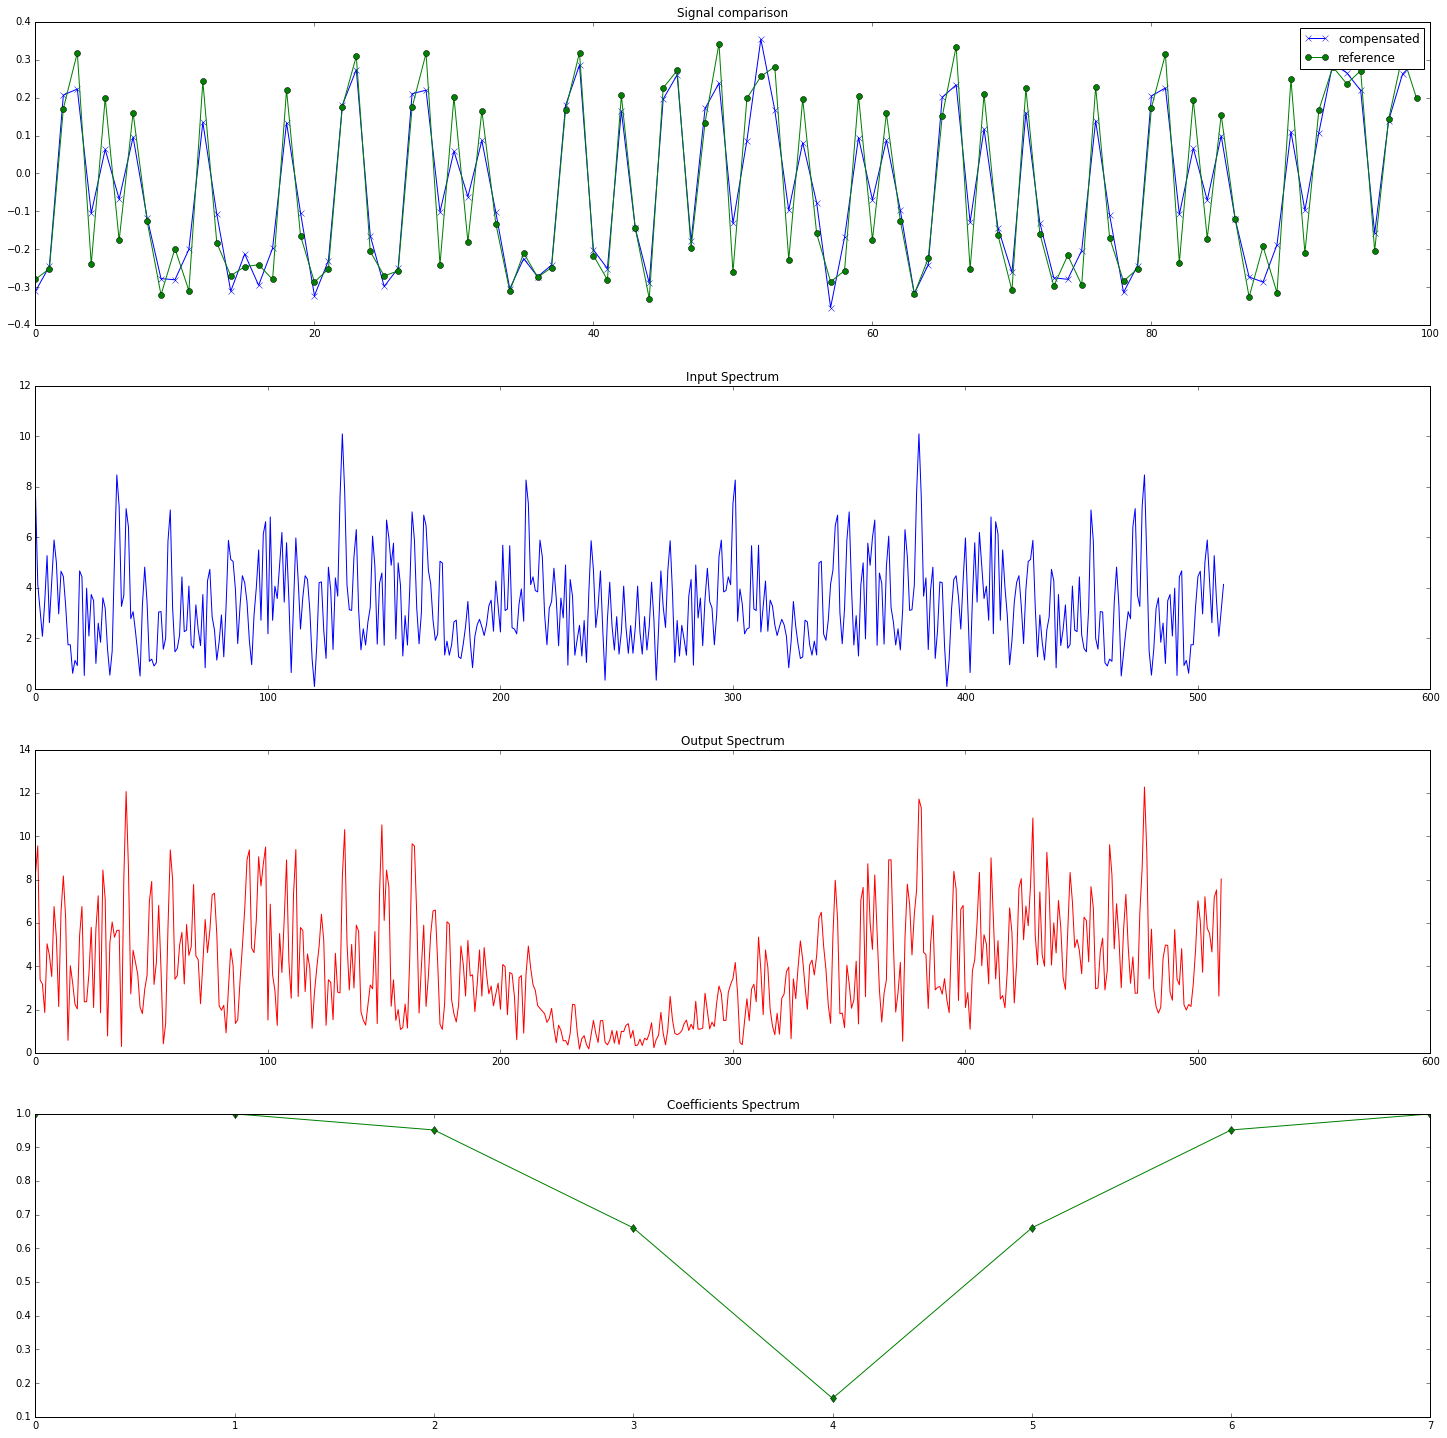

In [71]:
#pl.plot(y[1:],label='compensated')
#pl.plot(z[:100],'-x',label='compensated TD')
#pl.plot(skewed_data[3:],'-o',label='original with skew')
#pl.plot(sampled_data[3:103],'-d',label='original without skew')
pl.figure(figsize=(25,25))
pl.title('TD Results')
pl.subplot(4,1,1)
pl.title('Signal comparison')
pl.plot(z[:100],'-x',label='compensated')
pl.plot(sampled_data[3:103],'-o',label='reference')
pl.legend()
pl.subplot(4,1,2)
pl.title('Input Spectrum')
pl.plot(abs(np.fft.fft(np.real(skewed_data),512)))
pl.subplot(4,1,3)
pl.title('Output Spectrum')
pl.plot(abs(np.fft.fft(z,512))[:511],'r')
pl.subplot(4,1,4)
pl.title('Coefficients Spectrum')
pl.plot(np.abs(np.fft.fft(taps,8)),'g-d')

pl.legend()
pl.show()

Calculo de RMSD

In [72]:
def calc_fd_rmsd():
    rmsd = np.sqrt(sum([  np.abs(y[1+i]-sampled_data[1+i])**2 for i in range(len(sampled_data)-1)])/(len(sampled_data)-1))
    return rmsd
def calc_td_rmsd():
    rmsd = np.sqrt(sum([  np.abs(z[i]-sampled_data[3+i])**2 for i in range(len(z)-5)])/(len(z)-5))
    return rmsd

sk_in_samples=1
(sampled_data,skewed_data) = sample_data()
(x,y,f,g,phases)=fd_compensation()
z,taps=td_compensation()
print sk_in_samples,calc_td_rmsd(),calc_fd_rmsd()

sk_in_samples=13
(sampled_data,skewed_data) = sample_data()
(x,y,f,g,phases)=fd_compensation()
z,taps=td_compensation()
print sk_in_samples,calc_td_rmsd(),calc_fd_rmsd()

1 0.0196869010808 0.0164793574283
13 0.0563481623441 0.0565065788266


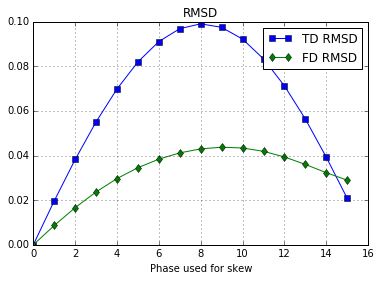

In [73]:
td_rmsd=[]
fd_rmsd=[]
fft_size=64
for i in range(16):
    sk_in_samples=i
    (sampled_data,skewed_data) = sample_data()
    (x,y,f,g,phases)=fd_compensation()
    z,taps=td_compensation()
    td_rmsd.append(calc_td_rmsd())
    fd_rmsd.append(calc_fd_rmsd())

pl.title('RMSD')
pl.plot(td_rmsd,'s-',label='TD RMSD')
pl.plot(fd_rmsd,'d-',label='FD RMSD')
pl.xlabel( 'Phase used for skew')
pl.grid()
pl.legend()
pl.show()

# Demostracion de que x(n)+j*y(n) = X(w)+Y(w)

In [74]:
x_real=np.random.random_sample(8)
y_real= np.random.random_sample(8)
X=np.fft.fft([np.complex(i,0) for i in x_real])
Y=np.fft.fft([np.complex(0,i) for i in y_real])
XY=np.fft.fft([np.complex(i,j) for i,j in zip(x_real,y_real)])
Z=X+Y
print Z-XY
print X



[  0.00000000e+00 +0.00000000e+00j   0.00000000e+00 -5.55111512e-17j
   0.00000000e+00 +0.00000000e+00j  -1.11022302e-16 +1.11022302e-16j
   0.00000000e+00 +0.00000000e+00j   5.55111512e-17 +5.55111512e-17j
   0.00000000e+00 +0.00000000e+00j  -8.32667268e-17 +5.55111512e-17j]
[ 3.38054268+0.j         -0.67201114+0.45109147j  0.32986152-1.60432818j
 -0.23163857-0.45375223j -0.59055960+0.j         -0.23163857+0.45375223j
  0.32986152+1.60432818j -0.67201114-0.45109147j]


# Calculo de recursos de filtro FD

In [77]:
parallelism=128
radix=16
n_ffts=math.ceil(parallelism/(radix-2.0))

#multiplicadores full del filtro (en 0 y N/2 es real, el resto son el producto y el producto de sus complejos
#se comparten productos parciales, se necesitan 4 multiplicadores full cada 2 taps, o sea 2 por tap )
multipliers=(2*(radix-2.0)+2)*n_ffts
adders=(2*(radix-2.0)+24*4)*n_ffts
reference_adders = 5*parallelism
reference_mults = 6*parallelism
print n_ffts,multipliers,reference_mults
print n_ffts,adders,reference_adders


10.0 300.0 768
10.0 1240.0 640
